In [20]:
''' Import libraries '''
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
from IPython.display import display

In [27]:
''' Load image using OpenCV '''
# Upload the LMS image to Google Drive and point to its location.
# Note OpenCV reads image as BGR.
# image_directory = '/home/phw93/dev/calib/data/*.jpg'
image_directory = '/home/phw/dev/calib/data/*.jpg'
image_files = glob.glob(image_directory)
image_files = sorted(image_files)
images = []
gray_images = []
for image_file in image_files:
    image = cv2.imread(image_file)
    # gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0
    images.append(image)
    gray_images.append(gray_image)
    
images_len = len(gray_images)
# Normalize image to between 0 and 1.
    
w, h = gray_images[0].shape
print(w, h)
print("image len: ", images_len)

1920 1080
image len:  114


float32
0.019607844 1.0


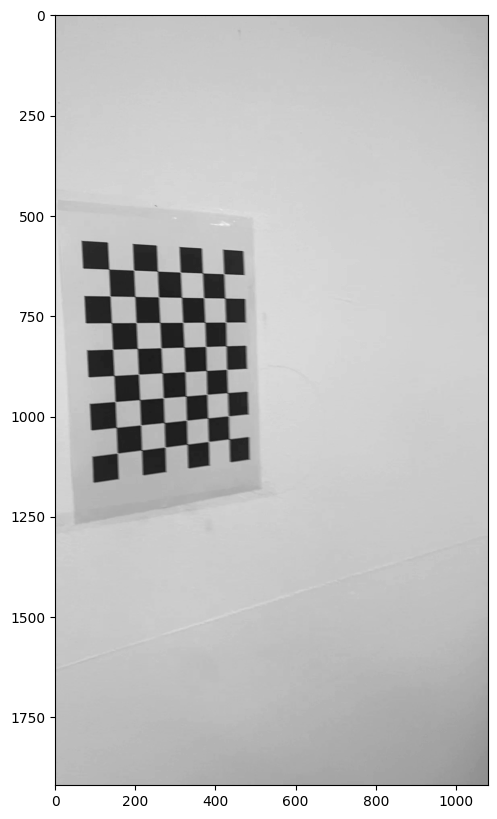

In [28]:
# Show output
print(gray_images[0].dtype)
print(np.min(gray_images[0]), np.max(gray_images[0]))
plt.figure(figsize=(10, 10))
plt.imshow(gray_images[5], cmap='gray')
plt.show()

In [29]:
# Perform Sobel filtering along the x-axis, y-axis.
arrIx = []
arrIy = []
sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

for gray_image in gray_images:
    Ix = cv2.filter2D(gray_image, -1, sobel_x)
    Iy = cv2.filter2D(gray_image, -1, sobel_y)
    arrIx.append(Ix)
    arrIy.append(Iy)

print(len(arrIx))    

114


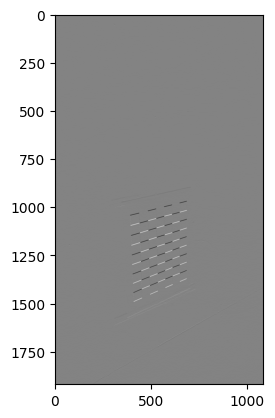

In [30]:
plt.imshow(arrIx[111], cmap='gray')
plt.imshow(arrIy[111], cmap='gray')

In [55]:
# extract corner & NMS
arrCorners = []
arrFiltCorners = []
window_size = 3
half_size = window_size // 2


for gray_image in gray_images:
    dst = cv2.cornerHarris(gray_image, blockSize=2, ksize=3, k=0.04)
    corners = []
    corners_y, corners_x = np.where(dst > 0.01 * dst.max())
    corners = np.column_stack((corners_x, corners_y))
    
    filtered_corners = []
    for corner_set in corners:
        corner_set_filtered = []
        for corner in corner_set:
            x, y = corner

            # 윈도우 내에서 최대값인지 확인
            window = corner_set[max(0, y - half_size):y + half_size + 1,
                                max(0, x - half_size):x + half_size + 1]
            if np.max(window) == corner[2] and corner[2] > 0.1:
                corner_set_filtered.append(corner)

        filtered_corners.append(np.array(corner_set_filtered))
    
    arrCorners.append(corners)
    arrFiltCorners.append(filtered_corners)
    
for corners in arrFiltCorners:
    print(len(corners))

TypeError: cannot unpack non-iterable numpy.int64 object

In [54]:
# non maximum suppress
arrFiltCorners = []
window_size = 21
half_size = window_size // 2
for corners in arrCorners:
    suppressed_corners = []
    for corner in corners:
        x, y = corner

        # 윈도우 내에서 최대값인지 확인
        window = corners[y - half_size:y + half_size + 1, x - half_size:x + half_size + 1]
        if window.size == 0:  # 윈도우가 비어 있는 경우 건너뜀
            continue
        if np.max(window) == corner[1]:
            suppressed_corners.append(corner)

    arrFiltCorners.append(np.array(suppressed_corners))
    
for corners in arrFiltCorners:
    print(len(corners))

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [ ]:
# draw corners
cornerImg = []
for image, corners in zip(images, arrCorners):
    temp = image.copy() 
    for corner in corners:
        x, y = corner
        cv2.drawMarker(temp, (x, y), color=(0, 0, 255), markerType=cv2.MARKER_STAR, markerSize=5, thickness=1)        
    cornerImg.append(temp)

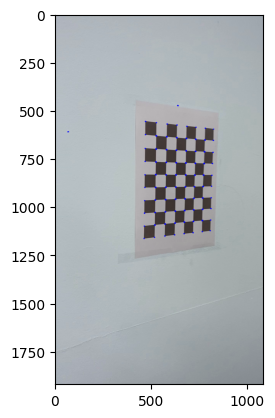

In [38]:
# 이미지 표시
plt.imshow(cornerImg[10], cmap='gray')

In [4]:
''' Approximate local error surface '''
window_size = 3
offset = int(np.floor(window_size/2)) 

det = np.zeros(img.shape)
trace = np.zeros(img.shape)

# For each pixel in image
for y in range(offset, img.shape[0]-offset):
  for x in range(offset, img.shape[1]-offset):
    
    # Build ROI window around the current pixel
    # Note numpy uses height-by-width convention (row x column)
    window_x = Ix[y-offset:y+offset+1, x-offset:x+offset+1]
    ''' DO IT YOURSELF for window_y '''
    window_y = Iy[y-offset:y+offset+1, x-offset:x+offset+1]
    

    # Estimate elements of matrix M.
    Sxx = np.sum(window_x * window_x)
    ''' DO IT YOURSELF for Syy and Sxy '''
    Syy = np.sum(window_y * window_y)
    Sxy = np.sum(window_x * window_y)

    # Compute determinant of M and trace of M.
    # Note numpy uses height-by-width convention (row x column)
    trace[y,x] = Sxx + Syy
    ''' DO IT YOURSELF for det[y,x] '''
    det[y,x] = Sxx*Syy - Sxy**2

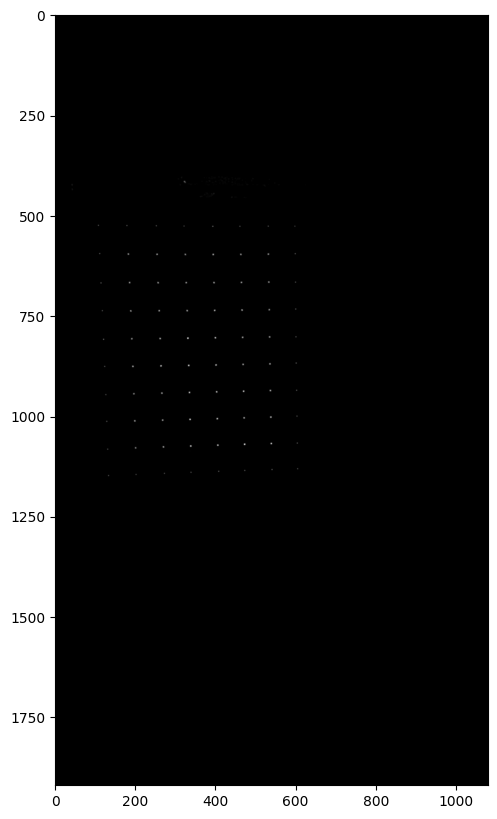

In [5]:
# Set hyperparameters
alpha = 0.04
beta = 0.01

# Compute response map
''' DO IT YOURSELF!: R - det(M) - alpha * trace(M)^2 '''
R = np.zeros(img.shape)
for y in range(offset, img.shape[0]-offset):
  for x in range(offset, img.shape[1]-offset):
    R[y,x] = det[y,x] - alpha * (trace[y,x]**2)
    max_R = 0
    
    if max_R < R[y,x]:
      max_R = R[y,x]
# max_R = np.argmax(R)
# print(max_R)
# Use thresholding to discard responses with low amplitude
''' DO IT YOURSELF! R is discarded if R < beta * max(R) '''
for y in range(offset, img.shape[0]-offset):
  for x in range(offset, img.shape[1]-offset):
    if R[y,x] < beta * max_R:
      R[y,x] = 0.0
# Smooth the response map using Gaussian filter
''' DO IT YOURSELF! Define gaussian_2d kernel as a numpy array. '''
gaussian_2d = np.array([[1/16, 2/16, 1/16], [2/16, 4/16, 2/16], [1/16, 2/16, 1/16]])
R = cv2.filter2D(R, -1, gaussian_2d)

# Show the response map
plt.figure(figsize=(10, 10))
plt.imshow(R, cmap='gray')
plt.show()


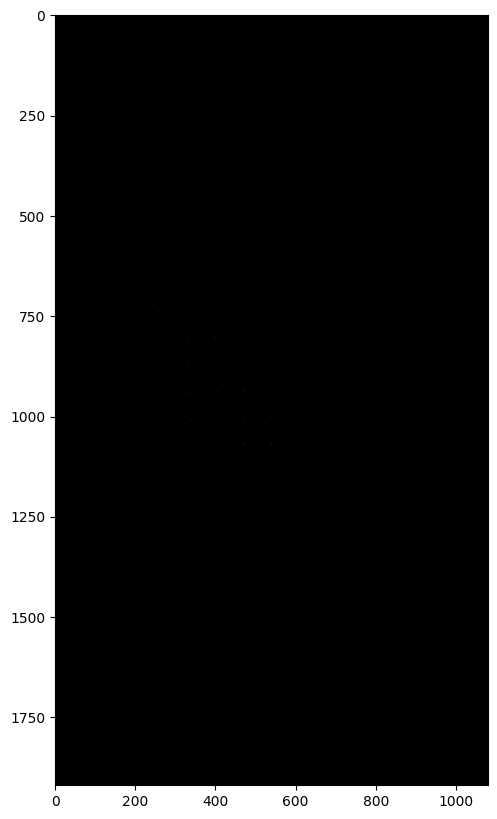

In [6]:
# Set NMS window size
window_size = 15
offset = int(np.floor(window_size/2))
output_img = np.zeros(img.shape)
features = set()
# For each pixel, perform non-maximal suppression around it in 3x3 block.
for y in range(offset, img.shape[0]-offset):
  for x in range(offset, img.shape[1]-offset):
    
    if R[y,x] == 0.0:
      # If the response map value is 0, then we can skip
      continue
    center_value = R[y,x]
    max_value = -100.0
    for m in range(y-offset, y+offset+1):
      for n in range(x-offset, x+offset+1):
        if max_value < R[m,n]:
          max_value = R[m,n]

    # If the center value is not the same as the maximum value of the 3x3 block, 
    # then it's not maximum, so suppress.
    # Otherwise, let the pixel survive.
    if center_value != max_value:
      R[y,x] = 0
      output_img[y,x] = R[y,x]
    else:
      output_img[y,x] = R[y,x]

plt.figure(figsize=(10, 10))
plt.imshow(R, cmap='gray')
plt.show()

In [7]:
''' Extract feature points and draw on the image '''
while()
y, x = np.where(output_img>25.0)

print(len(x)) # ideal 80
for i in range(0, len(x)):
  features.add((x[i], y[i]))
  output_vis = cv2.circle(img_bgr, (x[i], y[i]), 3, (0, 0, 255))
plt.imshow(output_vis, cmap='gray')

features_vec = list(features)
sorted_features = sorted(features_vec)
for pts in sorted_features:
  print(pts)

SyntaxError: invalid syntax (2277657935.py, line 2)